Testing FIBSEM Microscope overall class
    - Testing Thermo Fisher instance of class
    

Importing Relevant Modules

In [2]:
%load_ext autoreload
%autoreload 2

from fibsem import utils, acquire
import fibsem.alignment as fa
from fibsem.structures import BeamType, ImageSettings, GammaSettings, FibsemRectangle, FibsemImage, check_data_format
import matplotlib.pyplot as plt
from fibsem import FibsemMicroscope, calibration
import os
import logging
from fibsem.utils import current_timestamp, configure_logging
from pathlib import Path
from autoscript_sdb_microscope_client.structures import (
    AdornedImage,
    GrabFrameSettings,
    Rectangle,
    RunAutoCbSettings,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Importing settings from config

In [3]:
settings = utils.load_settings_from_config()


In [8]:
session_path: Path = None
config_path: Path = None
protocol_path: Path = None
setup_logging: bool = True

In [9]:
session = f'{settings.protocol["name"]}_{current_timestamp()}'
if protocol_path is None:
    protocol_path = os.getcwd()

# configure paths
if session_path is None:
    session_path = os.path.join(os.path.dirname(protocol_path), session)
os.makedirs(session_path, exist_ok=True)

# configure logging
if setup_logging:
    configure_logging(session_path)


# image_setttings
settings.image.save_path = session_path

logging.info(f"Finished setup for session: {session}")

2022-12-02 09:22:58,518 — root — INFO — <cell line: 18>:18 — Finished setup for session: demo_2022-12-02.09-22-58AM


Initialising a microscope instance (Thermo Fisher Microscope)

In [76]:
microscope = FibsemMicroscope.ThermoMicroscope()

Testing Connection 

In [78]:
microscope.connect_to_microscope(settings.system.ip_address)

2022-12-02 10:02:17,451 — root — INFO — connect_to_microscope:60 — Microscope client connecting to [10.0.0.1:7520]
Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]
2022-12-02 10:02:17,458 — root — INFO — connect_to_microscope:62 — Microscope client connected to [10.0.0.1:7520]


Setting up for image acquisition

In [16]:
print(settings)

MicroscopeSettings(system=SystemSettings(ip_address='10.0.0.1', application_file='autolamella', stage=StageSettings(rotation_flat_to_electron=49, rotation_flat_to_ion=229, tilt_flat_to_electron=35, tilt_flat_to_ion=52, pre_tilt=35, needle_stage_height_limit=0.0037), ion=BeamSystemSettings(beam_type=<BeamType.ION: 2>, voltage=30000, current=2e-11, detector_type='ETD', detector_mode='SecondaryElectrons', eucentric_height=0.0165, plasma_gas='Argon'), electron=BeamSystemSettings(beam_type=<BeamType.ELECTRON: 1>, voltage=2000, current=1e-12, detector_type='ETD', detector_mode='SecondaryElectrons', eucentric_height=0.00391, plasma_gas='Null'), manufacturer='Thermo'), image=ImageSettings(resolution='1536x1024', dwell_time=1e-06, hfw=0.00015, autocontrast=True, beam_type=<BeamType.ELECTRON: 1>, save=False, label='default_image', gamma=GammaSettings(enabled=True, min_gamma=0.15, max_gamma=1.8, scale_factor=0.01, threshold=46), save_path='c:\\Users\\Admin\\Github\\fibsem\\demo_2022-12-02.09-22-5

In [31]:
# set gamma settings
gamma_settings = GammaSettings(
        enabled=True,
        min_gamma=0.5,
        max_gamma=1.8,
        scale_factor=0.01,
        threshold=46,
    )

# set imaging settings
image_settings = ImageSettings(
        resolution="1536x1024",
        dwell_time=1.0e-6,
        hfw=150.0e-6,
        autocontrast=True,
        beam_type=BeamType.ELECTRON,
        gamma=gamma_settings,
        save=True,
        save_path="fibsem\\test_images",
        label=utils.current_timestamp(),
        reduced_area=None,
    )

frame_settings = GrabFrameSettings(
    resolution=image_settings.resolution,
    dwell_time=image_settings.dwell_time,
    reduced_area=image_settings.reduced_area,
)

 # set label
if image_settings.beam_type is BeamType.ELECTRON:
    label = f"{image_settings.label}_eb"

if image_settings.beam_type is BeamType.ION:
    label = f"{image_settings.label}_ib"

Autoconcrast

In [77]:
# microscope.autocontrast(beam_type=image_settings.beam_type)
# microscope.autocontrast(beam_type=BeamType.ION)



ApiException: Cannot perform a call because the client is not running.

Take new image

In [33]:
print(image_settings.save_path)
print(image_settings.label)

fibsem\test_images
2022-12-02-09-36-24AM


2022-12-02 09:50:16,979 — root — INFO — acquire_image:89 — acquiring new ELECTRON image.


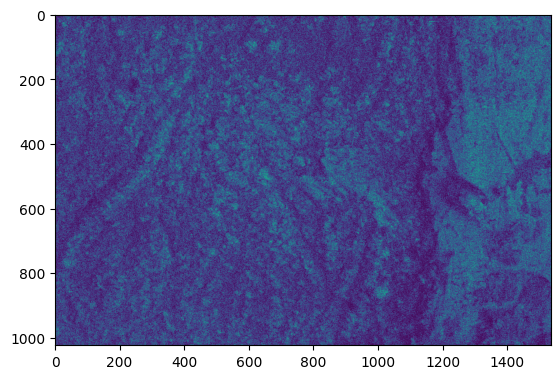

fibsem\test_images\2022-12-02-09-36-24AM_last
Image saved


In [57]:
new_image = microscope.acquire_image(frame_settings, image_settings)
# apply gamma correction
if image_settings.gamma.enabled:
    image = acquire.auto_gamma(new_image, image_settings.gamma)

plt.imshow(new_image.data)
plt.show()

# save image
if image_settings.save:
    filename = os.path.join(image_settings.save_path, label)
    image.save(save_path=filename)


    print(filename)

    assert os.path.exists(f"{filename}.tif")
    print("Image saved")

Checks

In [48]:
assert isinstance(new_image, FibsemImage)
check_data_format(new_image.data)
print(new_image.metadata.image_settings)
print(image_settings)
#assert new_image.metadata.image_settings == image_settings
assert new_image.metadata.version == 'v1'
assert new_image.metadata.microscope_state == calibration.get_current_microscope_state(microscope.connection)

ImageSettings(resolution='1536x1024', dwell_time=1e-06, hfw=0.00015, autocontrast=True, beam_type=<BeamType.ELECTRON: 1>, save=True, label='2022-12-02-09-36-24AM', gamma=GammaSettings(enabled=True, min_gamma=0.5, max_gamma=1.8, scale_factor=0.01, threshold=46), save_path='fibsem\\test_images', reduced_area=None)
ImageSettings(resolution='1536x1024', dwell_time=1e-06, hfw=0.00015, autocontrast=True, beam_type=<BeamType.ELECTRON: 1>, save=True, label='2022-12-02-09-36-24AM', gamma=GammaSettings(enabled=True, min_gamma=0.5, max_gamma=1.8, scale_factor=0.01, threshold=46), save_path='fibsem\\test_images', reduced_area=None)


AssertionError: 

Take last image

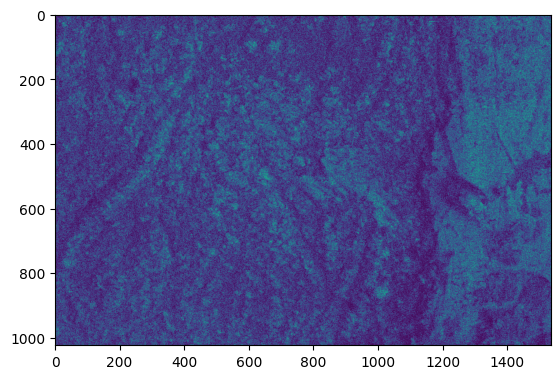

In [62]:
label = f"{image_settings.label}_last"

last_image = microscope.last_image(image_settings.beam_type)

plt.imshow(last_image.data)
plt.show()

if image_settings.save:
    filename = os.path.join(image_settings.save_path, label)
    image.save(save_path=filename)


Checks

In [66]:
assert isinstance(last_image, FibsemImage)
check_data_format(last_image.data)
#assert last_image.metadata.image_settings == image_settings
assert last_image.metadata.version == 'v1'
assert last_image.metadata.microscope_state == calibration.get_current_microscope_state(microscope.connection)

AssertionError: 

Beam shift

In [72]:
print("electron: ", microscope.connection.beams.electron_beam.beam_shift.value)
print("ion: ", microscope.connection.beams.ion_beam.beam_shift.value)

microscope.reset_beam_shifts()

print("electron: ", microscope.connection.beams.electron_beam.beam_shift.value)
print("ion: ", microscope.connection.beams.ion_beam.beam_shift.value)

assert microscope.connection.beams.electron_beam.beam_shift.value.x == 0
assert microscope.connection.beams.electron_beam.beam_shift.value.y ==  0

assert microscope.connection.beams.ion_beam.beam_shift.value.x == 0
assert microscope.connection.beams.ion_beam.beam_shift.value.y ==  0

electron:  Point(x=0, y=0)
ion:  Point(x=0, y=0)
electron:  Point(x=0, y=0)
ion:  Point(x=0, y=0)


Disconnect from Microscope

In [73]:
microscope.disconnect()

Client disconnected
